# REGALS analysis of NrdE AEX data

The data and analysis were published in:

**An endogenous dAMP ligand in Bacillus subtilis class Ib RNR promotes assembly of a noncanonical dimer for regulation by dATP**

Mackenzie J. Parker, Ailiena O. Maggiolo, William C. Thomas, Albert Kim, Steve P. Meisburger, Nozomi Ando, Amie K. Boal, JoAnne Stubbe

PNAS, May 2018, 115 (20), E4594-E4603; DOI: 10.1073/pnas.1800356115


In [1]:
%matplotlib inline

import sys
import os
sys.path.append(os.path.abspath('../python/'))

import h5py
import numpy as np

from regals import *

import matplotlib.pyplot as plt

## Load data

In [2]:
NrdE_mix_AEX = {}
with h5py.File('data/NrdE_mix_AEX.mat', 'r') as f:
    for key in f:
        NrdE_mix_AEX[key] = np.array(f[key])

#Store raw data
q = NrdE_mix_AEX['q'][0]
I = NrdE_mix_AEX['I'].T
sigma = NrdE_mix_AEX['sigma'].T
x = np.arange(I.shape[1])

## Set up REGALS calculation
Each component has a concentration and profile regularizer.

In [3]:
Bg1 = component(concentration_class('smooth',x, xmin = np.amin(x)-1E-3, xmax = np.amax(x)+1E-3, is_zero_at_xmin = False, is_zero_at_xmax = False),\
                profile_class('simple',q))

Bg2 = component(concentration_class('smooth',x, xmin = 201-1E-3, xmax = np.amax(x)+1E-3, is_zero_at_xmin = True, is_zero_at_xmax = False),\
                profile_class('simple',q))

C1 = component(concentration_class('smooth',x, xmin = 730, xmax = 1270),\
               profile_class('simple',q))

C2 = component(concentration_class('smooth',x, xmin = 1150, xmax = 1600),\
               profile_class('simple',q))

# create Mixture object and set regularization parameters
M = mixture([C1,C2,Bg1,Bg2])

## Run REGALS

In [4]:
# creat REGALS object
R = regals(I,sigma);

M.lambda_concentration = M.estimate_concentration_lambda(sigma,[np.Inf,np.Inf,8,8])
#M = R.auto_estimate_lambda(M) # NEW! (to try, uncomment and run)

# set stopFun to return true when 50 iterations is exceeded
stop_fun = lambda num_iter, params: [num_iter >= 50, 'max_iter']

update_fun = lambda num_iter, mix, params,resid: \
    print('%2d, x2 = %f, delta_profile = %s'%(num_iter,params['x2'],np.array2string(params['delta_profile'],precision=3)))

# run for 50 iterations
[M1,params,resid,exit_cond] = R.run(M, stop_fun, update_fun);

# extract the two particle components (no regularization)
[I1,sigma1] = M1.extract_profile(I,sigma,0);
[I2,sigma2] = M1.extract_profile(I,sigma,1);

 1, x2 = 1.121346, delta_profile = [360.072 362.423  83.838  57.351]
 2, x2 = 1.046124, delta_profile = [ 5.212  2.178 23.336 41.044]
 3, x2 = 1.025329, delta_profile = [ 2.25   0.579  9.011 10.821]
 4, x2 = 1.017813, delta_profile = [1.759 0.44  7.783 3.461]
 5, x2 = 1.015088, delta_profile = [1.047 0.26  4.768 1.68 ]
 6, x2 = 1.014013, delta_profile = [0.667 0.154 2.587 1.093]
 7, x2 = 1.013524, delta_profile = [0.46  0.094 1.237 1.252]
 8, x2 = 1.013261, delta_profile = [0.331 0.059 0.501 1.482]
 9, x2 = 1.013097, delta_profile = [0.251 0.038 0.125 1.642]
10, x2 = 1.012980, delta_profile = [0.195 0.026 0.073 1.726]
11, x2 = 1.012888, delta_profile = [0.152 0.018 0.152 1.767]
12, x2 = 1.012808, delta_profile = [0.118 0.013 0.189 1.783]
13, x2 = 1.012737, delta_profile = [0.092 0.009 0.205 1.785]
14, x2 = 1.012670, delta_profile = [0.072 0.007 0.209 1.782]
15, x2 = 1.012607, delta_profile = [0.057 0.005 0.208 1.776]
16, x2 = 1.012546, delta_profile = [0.045 0.004 0.205 1.768]
17, x2 =

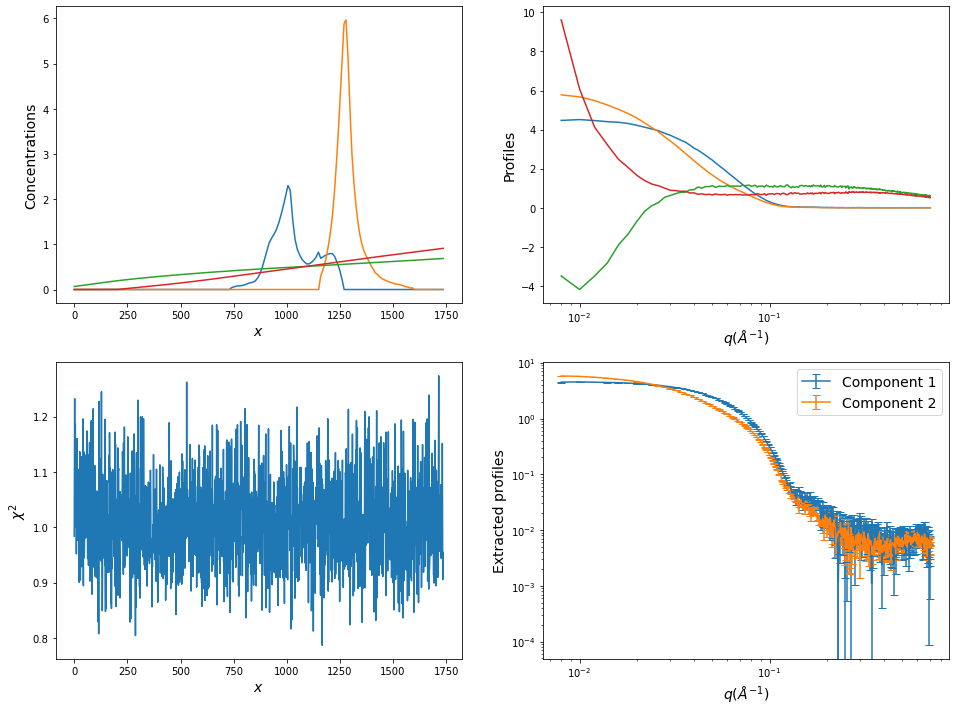

In [5]:
# plot the end results
plt.rcParams['figure.figsize'] = 16, 12
fig, axs = plt.subplots(2, 2)

#concentrations vs x
axs[0, 0].plot(x, M1.concentrations)
axs[0, 0].set_xlabel('$x$', fontsize=14)
axs[0, 0].set_ylabel('Concentrations', fontsize=14)

#chi2 vs x
axs[1, 0].plot(x, np.mean(resid ** 2, 0))
axs[1, 0].set_xlabel('$x$', fontsize=14)
axs[1, 0].set_ylabel('$\chi^2$', fontsize=14)

#profiles vs q
axs[0, 1].semilogx(q, M1.profiles)
axs[0, 1].set_xlabel('$q (Å^{-1})$', fontsize=14)
axs[0, 1].set_ylabel('Profiles', fontsize=14)

#extracted profiles
axs[1, 1].errorbar(q, I1, sigma1, capsize=4, label='Component 1')
axs[1, 1].errorbar(q, I2, sigma2, capsize=4, label='Component 2')
axs[1, 1].set_xscale('log')
axs[1, 1].set_yscale('log')
axs[1, 1].set_xlabel('$q (Å^{-1})$', fontsize=14)
axs[1, 1].set_ylabel('Extracted profiles', fontsize=14)
plt.legend(fontsize=14)

plt.show()